In [11]:
# model predicts the min and max value for the next 60 days
from tvDatafeed import TvDatafeed, Interval
tv = TvDatafeed()
vix = tv.get_hist(symbol="VIX", exchange="PEPPERSTONE", interval=Interval.in_daily, n_bars=180)
# vix = tv.get_hist(symbol="VIX", exchange="PEPPERSTONE", interval=Interval.in_daily, n_bars=2000)
vix.to_csv('predout.csv')

In [12]:
from keras.models import load_model
import keras.backend as k
from datetime import datetime
def loss_function(y_true, y_pred):
    """
    Custom MSE-function that makes predicted values smaller than the actual value less impactful/important
    """
    loss_tensor = k.mean(k.abs(y_pred - y_true), axis=-1)
    loss_tensor = k.switch(k.greater(y_pred[-1], y_true[-1]), loss_tensor, loss_tensor/2)
    return loss_tensor

# minactual: loss_tensor = k.switch(k.greater(y_pred[-1], y_true[-1]), loss_tensor*2, loss_tensor/1000)
# maxactual: loss_tensor = k.switch(k.greater(y_pred[-1], y_true[-1]), loss_tensor, loss_tensor/2)


model_max=load_model("test_max.h5",
                 custom_objects= {"loss_function": loss_function})
model_min=load_model("test_min.h5",
                 custom_objects= {"loss_function": loss_function})

In [13]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
column_names = ['datetime','symbol','open','high','low','close','volume']
dataframe = pd.read_csv("predout.csv", header=0)
dataframe['close'] = dataframe['close'].clip(upper=40)
print(dataframe)

                datetime           symbol   open   high    low  close   volume
0    2022-07-14 00:00:00  PEPPERSTONE:VIX  27.90  28.98  27.67  27.77  12240.0
1    2022-07-15 00:00:00  PEPPERSTONE:VIX  27.76  28.10  26.32  26.43   6022.0
2    2022-07-18 01:00:00  PEPPERSTONE:VIX  26.36  27.49  26.13  27.19   3506.0
3    2022-07-19 00:00:00  PEPPERSTONE:VIX  27.19  27.25  26.42  26.83   3062.0
4    2022-07-20 00:00:00  PEPPERSTONE:VIX  26.83  27.15  26.23  26.47   4814.0
..                   ...              ...    ...    ...    ...    ...      ...
175  2023-03-20 00:00:00  PEPPERSTONE:VIX  25.68  28.14  24.69  24.84  21380.0
176  2023-03-20 23:00:00  PEPPERSTONE:VIX  24.84  24.95  22.61  22.76   7286.0
177  2023-03-21 23:00:00  PEPPERSTONE:VIX  22.86  23.61  21.88  23.56  12004.0
178  2023-03-22 23:00:00  PEPPERSTONE:VIX  23.51  24.60  22.00  23.88  14790.0
179  2023-03-23 23:00:00  PEPPERSTONE:VIX  23.86  26.17  23.21  23.34  21532.0

[180 rows x 7 columns]


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 213ms/step
[[17.404903]]
[[28.712955]]


Text(190, 29.412955474853515, '28.713')

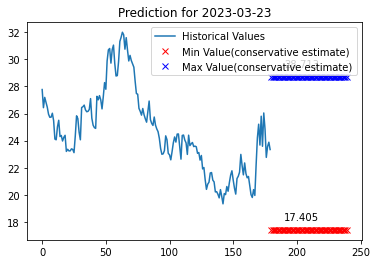

In [15]:
close_data = dataframe['close']
def normalize(test_data, mean, std):
    return (test_data - mean) / std

def de_normalize(output_data, mean, std):
    return output_data * std + mean

mean = 19.548277033033017
std = 6.891276427284751
# close_data.plot(x="Index Value", y="Step")
plot_ = plt.subplot()
plot_.plot(close_data)

close_data = normalize(close_data, mean, std)
#close_data.plot(x="Index Value", y="Step")

tensor = tf.convert_to_tensor(close_data.values)
tensor = tf.expand_dims(tensor, 0)
tensor = tf.expand_dims(tensor, -1)

val_max = model_max.predict(tensor)
val_max = de_normalize(val_max, mean, std)
val_min = model_min.predict(tensor)
val_min = de_normalize(val_min, mean, std)

print(val_min)
print(val_max)


plot_.set_title("Prediction for " + str(pd.to_datetime(dataframe['datetime'].iloc[-1]).date()))

for i in range(180,240):
    plot_.plot(i, val_min[0], "rx")
    plot_.plot(i, val_max[0], "bx")
plot_.legend(["Historical Values", "Min Value(conservative estimate)", "Max Value(conservative estimate)"])
plot_.annotate(str(round(val_min[0][0], 3)), [190, val_min[0][0]+0.7])
plot_.annotate(str(round(val_max[0][0], 3)), [190, val_max[0][0]+0.7])